## Test your analytics skills by predicting which New York Times blog articles will be the most popular.

Newspapers and online news aggregators like Google News need to understand which news articles will be the most popular, so that they can prioritize the order in which stories appear. In this competition, you will predict the popularity of a set of New York Times blog articles from the time period September 2014-December 2014.

The following screenshot shows an example of the New York Times technology blog "Bits" homepage:

![](https://kaggle2.blob.core.windows.net/competitions/kaggle/4347/media/NYBlogScreenshot_031715.png)

Many blog articles are published each day, and the New York Times has to decide which articles should be featured. In this competition, we challenge you to develop an analytics model that will help the New York Times understand the features of a blog post that make it popular.

#Read in training and testing sets

Originally these data files could be found at this [link](https://www.kaggle.com/c/15-071x-the-analytics-edge-competition-spring-2015/download/NYTimesBlogTest.csv), but the Jupyter R kernal does not support direct read.csv from a url.

The codebook for the two datatsets are nearly identical with only the "Popular" feature missing from the testing set.

##File Descriptions

The data provided for this competition is split into two files:

NYTimesBlogTrain.csv = the training data set. It consists of 6532 articles.

NYTimesBlogTest.csv = the testing data set. It consists of 1870 articles.  

We have also provided a sample submission file, SampleSubmission.csv. This file gives an example of the format of submission files (see the Evaluation page for more information). The data for this competition comes from the New York Times website.

###Variable Descriptions

The dependent variable in this problem is the variable Popular, which labels if an article had 25 or more comments in its online comment section (equal to 1 if it did, and 0 if it did not). The dependent variable is provided in the training data set, but not the testing dataset. This is an important difference from what you are used to - you will not be able to see how well your model does on the test set until you make a submission on Kaggle.

The independent variables consist of 8 pieces of article data available at the time of publication, and a unique identifier:

NewsDesk = the New York Times desk that produced the story (Business, Culture, Foreign, etc.)

SectionName = the section the article appeared in (Opinion, Arts, Technology, etc.)

SubsectionName = the subsection the article appeared in (Education, Small Business, Room for Debate, etc.)

Headline = the title of the article

Snippet = a small portion of the article text

Abstract = a summary of the blog article, written by the New York Times

WordCount = the number of words in the article

PubDate = the publication date, in the format "Year-Month-Day Hour:Minute:Second"

UniqueID = a unique identifier for each article


In [18]:

nytTrain = read.csv( "NYTimesBlogTrain.csv", stringsAsFactors = FALSE )
nytUNK   = read.csv( "NYTimesBlogTest.csv",  stringsAsFactors = FALSE )
 ##make the Train and Test sets conformable by adding column to test set with value of '2' as unknonw
nytUNK$Popular = rep( 2, dim( nytUNK )[ 1 ] )

##print out summary stats
str( nytTrain )
summary( nytTrain )


'data.frame':	6532 obs. of  10 variables:
 $ NewsDesk      : chr  "Business" "Culture" "Business" "Business" ...
 $ SectionName   : chr  "Crosswords/Games" "Arts" "Business Day" "Business Day" ...
 $ SubsectionName: chr  "" "" "Dealbook" "Dealbook" ...
 $ Headline      : chr  "More School Daze" "New 96-Page Murakami Work Coming in December" "Public Pension Funds Stay Mum on Corporate Expats" "Boot Camp for Bankers" ...
 $ Snippet       : chr  "A puzzle from Ethan Cooper that reminds me that a bill is due." "The Strange Library will arrive just three and a half months after Mr. Murakamis latest novel, Colorless Tsukuru Tazaki and His"| __truncated__ "Public pension funds have major stakes in American companies moving overseas to cut their tax bills. But they are saying little"| __truncated__ "As they struggle to find new business to bolster sluggish earnings, banks consider the nations 25 million veterans and service "| __truncated__ ...
 $ Abstract      : chr  "A puzzle from Ethan Coop

   NewsDesk         SectionName        SubsectionName       Headline        
 Length:6532        Length:6532        Length:6532        Length:6532       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
   Snippet            Abstract           WordCount         PubDate         
 Length:6532        Length:6532        Min.   :    0.0   Length:6532       
 Class :character   Class :character   1st Qu.:  187.0   Class :character  
 Mode  :character   Mode  :character   Median :  374.0   Mode  :character  
                                       Mean   :  524.4                     
                                       3rd Qu.:  723.2                     
     

In [19]:
nytUNK$words = paste(nytUNK$Headline,nytUNK$Snippet,nytUNK$Abstract)
nytUNK$words = gsub("New York","",nytUNK$words)
nytUNK$words = gsub("Times","",nytUNK$words)
nytUNK$words = gsub("report","",nytUNK$words)

nytUNK$PubDate = strptime(nytUNK$PubDate,'%Y-%m-%d %H:%M:%S')
nytUNK$hour    = format(nytUNK$PubDate,'%H')
nytUNK$dow     = format(nytUNK$PubDate,'%A')

nytTrain$words = paste(nytTrain$Headline,nytTrain$Snippet,nytTrain$Abstract)
nytTrain$words = gsub("New York","",nytTrain$words)
nytTrain$words = gsub("Times","",nytTrain$words)
nytTrain$words = gsub("report","",nytTrain$words)

nytTrain$PubDate = strptime(nytTrain$PubDate,'%Y-%m-%d %H:%M:%S')
nytTrain$hour    = format(nytTrain$PubDate,'%H')
nytTrain$dow     = format(nytTrain$PubDate,'%A')


###Install R text processing tm and snowballC libraries.

In [20]:
library(tm)
library(SnowballC)

In [21]:
corpus  = Corpus(VectorSource(c(nytTrain$words,nytUNK$words)))
corpus = tm_map(corpus, PlainTextDocument)
corpus = tm_map(corpus, tolower)
corpus = tm_map(corpus, PlainTextDocument)
corpus = tm_map(corpus, removePunctuation)
corpus = tm_map(corpus, removeWords, stopwords("english"))
corpus = tm_map(corpus, stemDocument)
dtm = DocumentTermMatrix(corpus)

dtm

<<DocumentTermMatrix (documents: 8402, terms: 16278)>>
Non-/sparse entries: 135222/136632534
Sparsity           : 100%
Maximal term length: 112
Weighting          : term frequency (tf)

In [22]:
spdtm = removeSparseTerms(dtm, 0.99)
spdtm
nytSparse     = as.data.frame(as.matrix(spdtm))
colnames(nytSparse) = make.names(colnames(nytSparse))

rev(sort(colSums(nytSparse)))[1]
nytSparse$Popular = c(nytTrain$Popular,nytUNK$Popular)

nytSparse$Popular = as.factor(nytSparse$Popular)
nytSparse$WordCount    = c(nytTrain$WordCount,nytUNK$WordCount)

nytSparse$NewsDesk    = as.factor(c(nytTrain$NewsDesk,nytUNK$NewsDesk))
nytSparse$SectionName    = as.factor(c(nytTrain$SectionName,nytUNK$SectionName))
nytSparse$SubsectionName    = as.factor(c(nytTrain$SubsectionName,nytUNK$SubsectionName))

nytSparse$hour    = as.factor(c(nytTrain$hour,nytUNK$hour))
nytSparse$dow     = as.factor(c(nytTrain$dow,nytUNK$dow))

nytTESTset = subset(nytSparse,Popular=='2')
nytTESTset$Popular = droplevels(nytTESTset$Popular)

nytSparse = subset(nytSparse,Popular %in% c('0','1'))
nytSparse$Popular = droplevels(nytSparse$Popular)


<<DocumentTermMatrix (documents: 8402, terms: 301)>>
Non-/sparse entries: 49215/2479787
Sparsity           : 98%
Maximal term length: 12
Weighting          : term frequency (tf)

new 
1974

In [24]:
library(caTools)
set.seed(123)
split = sample.split(nytSparse$Popular, SplitRatio = 0.7)

train = subset(nytSparse, split==TRUE)
test  = subset(nytSparse, split==FALSE)


###Logistic Regression Model

In [29]:
library(ROCR)

cat("Logistic regression model results on training and test sets")

nytLog = glm( Popular ~ ., data = train, family = binomial )

##training set
predPopularLog = predict(nytLog, type="response")
x=table(train$Popular, predPopularLog >= 0.5)
##baseline from confusion matrix
cat(paste("Training set baseline prediction: ",round(sum(diag(x))/nrow(train),2),"\n"))

ROCRpred = prediction(predPopularLog, train$Popular)
cat(paste("Training set Area Under Curve:    ",round(as.numeric(performance(ROCRpred, "auc")@y.values),2),"\n"))


##test set
predPopularLog = predict(nytLog, newdata=test, type="response")
x<-table(test$Popular, predPopularLog >= 0.5)
##baseline from confusion matrix
cat(paste("Testing set baseline prediction:  ",round(sum(diag(x))/nrow(test),2),"\n"))
ROCRpred = prediction(predPopularLog, test$Popular)
cat(paste("Testing set Area Under Curve:     ",round(as.numeric(performance(ROCRpred, "auc")@y.values),2),"\n"))


Warning message:
: glm.fit: fitted probabilities numerically 0 or 1 occurred

Training set baseline prediction:  0.9285 
Training set Area Under Curve:     0.96 


Warning message:
In predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == : prediction from a rank-deficient fit may be misleading

Testing set baseline prediction:   0.8954 
Testing set Area Under Curve:      0.91 


##CART - Classification and Regression Tree model

CART model results on training and test sets

   predictCART
       0    1
  0 3715   92
  1  328  437

Training set baseline prediction:  0.91 
Training set Area Under Curve:     0.78 


   predictCART
       0    1
  0 1579   53
  1  138  190

Testing set baseline prediction:   0.9 
Testing set Area Under Curve:      0.77 


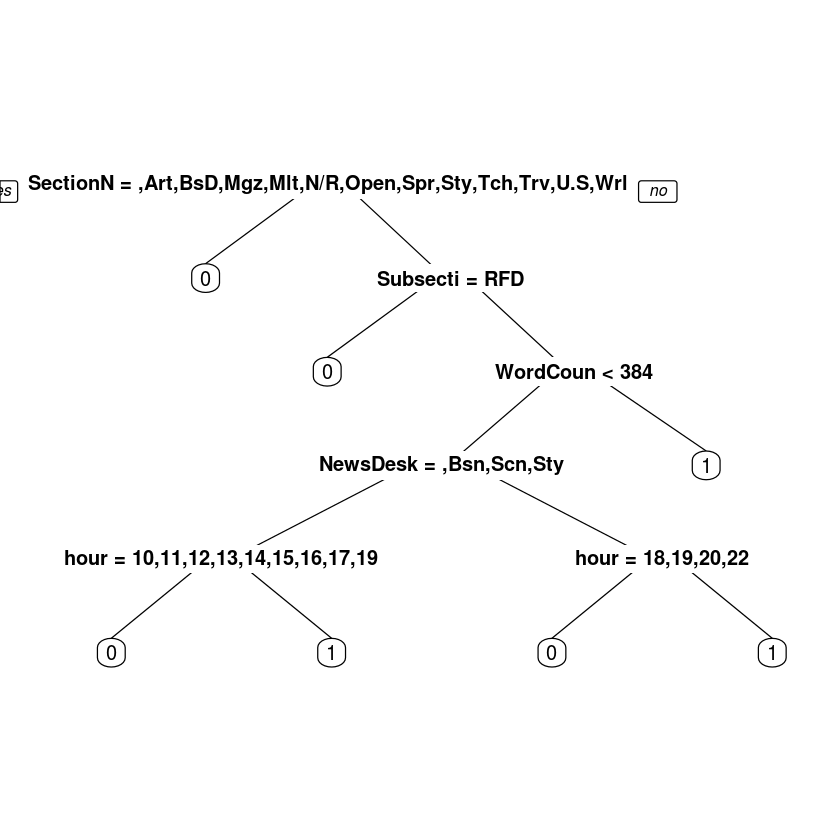

In [30]:
library(rpart)
library(rpart.plot)

cat("CART model results on training and test sets")

nytCART = rpart(Popular ~ ., data=train, method="class")
prp(nytCART)


predictCART = predict(nytCART, newdata=train, type="class")
table(train$Popular, predictCART)
# Compute accuracy
cat(paste("Training set baseline prediction: ",round(sum(diag(table(train$Popular, predictCART)))/nrow(train),2),"\n"))


predictCART = predict(nytCART, newdata=train)[,2]
ROCRpred = prediction(predictCART, train$Popular)
cat(paste("Training set Area Under Curve:    ",round(as.numeric(performance(ROCRpred, "auc")@y.values),2),"\n"))


##test set
predictCART = predict(nytCART, newdata=test, type="class")
table(test$Popular, predictCART)
# Compute accuracy
cat(paste("Testing set baseline prediction:  ",round(sum(diag(table(test$Popular, predictCART)))/nrow(test),2),"\n"))

predictCART = predict(nytCART, newdata=test)[,2]
ROCRpred = prediction(predictCART, test$Popular)
cat(paste("Testing set Area Under Curve:     ",round(as.numeric(performance(ROCRpred, "auc")@y.values),2),"\n"))


##Random Forest model

In [32]:
library(randomForest)
set.seed(123)

cat("Random Forest model results on training and test sets")

nytRF = randomForest(Popular ~ ., data=train )  ##, ntree = 10000)

##Training set
predictRF = predict(nytRF, newdata=train, type="class")
table(train$Popular, predictRF)
# Compute accuracy
cat(paste("Training set baseline prediction: ",round(sum(diag(table(train$Popular, predictRF)))/nrow(train),2),"\n"))

predictRF = predict(nytRF, newdata=train, type='prob')[,2]
ROCRpred = prediction(predictRF, train$Popular)
cat(paste("Training set Area Under Curve:    ",round(as.numeric(performance(ROCRpred, "auc")@y.values),2),"\n"))


##test set
predictRF = predict(nytRF, newdata=test, type="class")
table(test$Popular, predictRF)
# Compute accuracy
cat(paste("Testing set baseline prediction:  ",round(sum(diag(table(test$Popular, predictRF)))/nrow(test),2),"\n"))

predictRF = predict(nytRF, newdata=test, type='prob')[,2]
ROCRpred = prediction(predictRF, test$Popular)
cat(paste("Testing set Area Under Curve:     ",round(as.numeric(performance(ROCRpred, "auc")@y.values),2),"\n"))


randomForest 4.6-10
Type rfNews() to see new features/changes/bug fixes.


Random Forest model results on training and test sets

   predictRF
       0    1
  0 3784   23
  1   26  739

Training set baseline prediction:  0.99 
Training set Area Under Curve:     1 


   predictRF
       0    1
  0 1568   64
  1  108  220

[1] 0.9122449

Testing set baseline prediction:   0.91 


[1] 0.9339711

Testing set Area Under Curve:      0.93 


##Evaluation

The evaluation metric for this competition is AUC. The AUC, which we described in Unit 3 when we taught logistic regression, is a commonly used evaluation metric for binary classification problems like this one. The interpretation is that given a random positive observation and negative observation, the AUC gives the proportion of the time you guess which is which correctly. It is less affected by sample balance than accuracy. A perfect model will score an AUC of 1, while random guessing will score an AUC of around 0.5.

##Submission File

For every observation in the test set, submission files should contain two columns: UniqueID and Probability1. The submission should be a csv file. The UniqueID should just be the corresponding UniqueID column from the test dataset. The Probability1 column should be the predicted probability of the outcome 1 according to your model, for that UniqueID. We have provided an example of a submission file, SampleSubmission.csv, which can be found in the Data section on Kaggle.

As an example of how to generate a submission file in R, suppose that your test set probability predictions are called "testPred" and your test data set is called "test". Then you can generate a submission file called "submission.csv" by running the following two lines of code in R (if you copy and paste these lines of code into R, the quotes around submission.csv might not read properly - please delete and re-type the quotes if you get an error):

submission = data.frame(UniqueID = test$UniqueID, Probability1 = testPred)
write.csv(submission, "submission.csv", row.names=FALSE)

You should then submit the file "submission.csv" by clicking on "Make a Submission" on the Kaggle website.

If you take a look at the file "submission.csv", you should see that the file contains a header and has the following format:

UniqueID,Probability1

6533,0.279672578

6534,0.695794648

6535,0.695794648

6536,0.279672578

6537,0.554216867

6538,0.640816327

6539,0.695794648

etc.

##Results
The second submission entry below produced a 90.2% accuracy on the hidden test datatset for a rank of 294 out of 2923  entries placing it in the top 10% of all contestants.

In [33]:
predTest = predict(nytRF, newdata=nytTESTset, type='prob',prec=6)[,2]
MySubmission = data.frame(UniqueID = nytUNK$UniqueID, Probability1 = as.numeric(predTest))
write.csv(MySubmission, "Submission1.csv", row.names=FALSE)


##nytRFall = randomForest(Popular ~ ., data=rbind(train,test), ntree=10000  )
nytRFall = randomForest(Popular ~ ., data=nytSparse)##, ntree=10000  )
predTest = predict(nytRFall, newdata=nytTESTset, type='prob',prec=6)[,2]
MySubmission4 = data.frame(UniqueID = nytUNK$UniqueID, Probability1 = predTest)
write.csv(MySubmission4, "Submission2.csv", row.names=FALSE)

